# Modern Data Analytics [G0Z39a]

## Project: Covid 19 in the USA

### Load packages

In [9]:
import mda_module_009 as mda

import os
import pandas as pd
import numpy as np

import yfinance as yf

import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px

import plotly.offline as py
py.init_notebook_mode(connected=True)
# jupyter notebook: notebook
#jupyter lab: plotly_mimetype
pio.renderers.default = 'plotly_mimetype' 
  
import matplotlib.pyplot as plt

import datetime as dt

import ipywidgets as widgets
from IPython.display import display
from IPython.display import Markdown as md

from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

### Load data

In [3]:
cwd = os.getcwd()
us = pd.read_csv(cwd+"/covid-19-data/us.csv")
counties_df = pd.read_csv(cwd+"/covid-19-data/us-counties.csv")
states_df = pd.read_csv(cwd+"/covid-19-data/us-states.csv")
counties20 = pd.read_csv(cwd+"/covid-19-data/us-counties-2020.csv")
counties21 = pd.read_csv(cwd+"/covid-19-data/us-counties-2021.csv")
counties22 = pd.read_csv(cwd+"/covid-19-data/us-counties-2022.csv")
extra_data = pd.read_csv(cwd+"/data/extra_data.csv")
dfpop = pd.read_csv(cwd+'/data/pop_usa_states.csv')

### Data Pre-Processing

In [4]:
counties20_clean = mda.counties_preprocessing(counties20)
counties21_clean = mda.counties_preprocessing(counties21)
counties22_clean = mda.counties_preprocessing(counties22)

### Data Info

In [5]:
perstate20 = mda.per_state(counties20_clean)
perstate21 = mda.per_state(counties21_clean)
perstate22 = mda.per_state(counties22_clean)
percounty20 = mda.per_county(counties20_clean)
percounty21 = mda.per_county(counties21_clean)
percounty22 = mda.per_county(counties22_clean)

In [6]:
state_stats20 = pd.DataFrame(counties20_clean.groupby('state').describe())
state_stats21 = pd.DataFrame(counties21_clean.groupby('state').describe())
state_stats22 = pd.DataFrame(counties22_clean.groupby('state').describe())

In [7]:
county_stats20 = pd.DataFrame(counties20_clean.groupby('county').describe())
county_stats21 = pd.DataFrame(counties21_clean.groupby('county').describe())
county_stats22 = pd.DataFrame(counties22_clean.groupby('county').describe())

### Map

In [8]:
mapdf = mda.extra_data_retriever(extra_data, mda.state_per_month(states_df))

In [10]:
def fig_creator(s):
    import plotly.express as px
    
    fig = px.scatter_geo(mapdf, locations="code", locationmode="USA-states", hover_name="state",
                     hover_data=["cases", "deaths", "1_dose", "complete_dose"], size=s, size_max=20,
                     animation_frame="date", projection="albers usa", title="Covid-19 evolution in US per state", width=1000, height=1000)
    fig.show()

widgets.interact(fig_creator,
                 s=widgets.Dropdown(
                     options=[("Cases", "cases"),
                              ("Deaths", "deaths"),
                              ("One Vaccination Dose", "1_dose"),
                              ("Complete Vaccination", "complete_dose")],
                     description='Select:'));

interactive(children=(Dropdown(description='Select:', options=(('Cases', 'cases'), ('Deaths', 'deaths'), ('One…

### Time Series plot

In [11]:
us_timeseries = mda.timeseries_process(us, "us")
state_timeseries = mda.timeseries_process(states_df, "state")
counties = pd.concat([counties20_clean, counties21_clean, counties22_clean])
counties_timeseries = mda.timeseries_process(counties, "county")

In [12]:
dropdown_case = widgets.Dropdown(options=[("Daily Cases", 'daily_cases'), ("Daily Deaths", 'daily_deaths')])
dropdown_level = widgets.Dropdown(options=[('USA','us'),('State','state'), ('County','county')])
dropdown_state = widgets.Dropdown(options=state_timeseries['state'].unique())
dropdown_county = widgets.Dropdown(options=counties_timeseries['county'].unique())
input_widgets = widgets.HBox([dropdown_case, dropdown_level])

output = widgets.Output()
def com_filter(case, level, state, county):
    output.clear_output()
    if level == 'us':
        with output:
            mda.plot(us_timeseries, level="us", y=case)
    elif level == "state":
        with output:
            display(dropdown_state)
            mda.plot(state_timeseries, level="state", y=case, state=state)
    elif level == "county":
        with output:
            display(dropdown_county)
            mda.plot(counties_timeseries, level="county", y=case, county=county)

def dropdown_case_eventhandler(change):
    com_filter(change.new, dropdown_level.value, dropdown_state.value, dropdown_county.value)

def dropdown_level_eventhandler(change):
    com_filter(dropdown_case.value, change.new, dropdown_state.value, dropdown_county.value)    
    
def dropdown_state_eventhandler(change):
    com_filter(dropdown_case.value, dropdown_level.value, change.new, dropdown_county.value)
    
def dropdown_county_eventhandler(change):
    com_filter(dropdown_case.value, dropdown_level.value, dropdown_state.value, change.new)
    
dropdown_case.observe(dropdown_case_eventhandler, names='value')
dropdown_level.observe(dropdown_level_eventhandler, names='value')
dropdown_state.observe(dropdown_state_eventhandler, names='value')
dropdown_county.observe(dropdown_county_eventhandler, names='value')
display(input_widgets)
display(output)

#initial plot
with output:
    mda.plot(us_timeseries, level="us", y='daily_cases')

Output()

#### Trend and Seasonality in the US

In [13]:
usa_time = us_timeseries.set_index('date')
usa_time.dropna(inplace=True)
decompose_result_mult = seasonal_decompose(usa_time['daily_cases'],period=365)
trend = decompose_result_mult.trend
seasonality = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

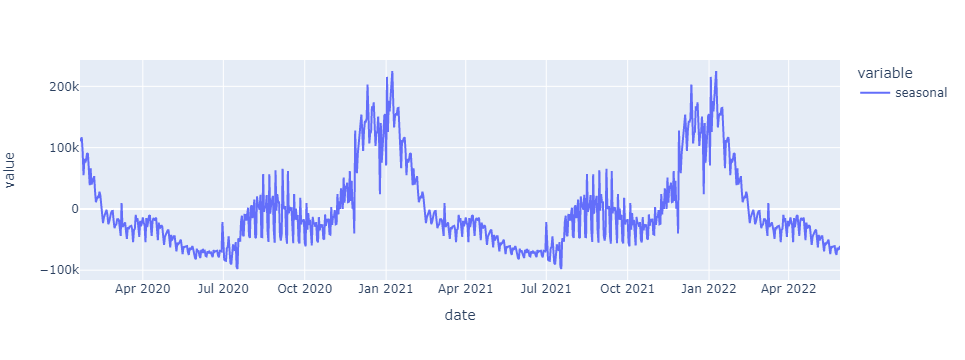

In [14]:
px.line(seasonality)

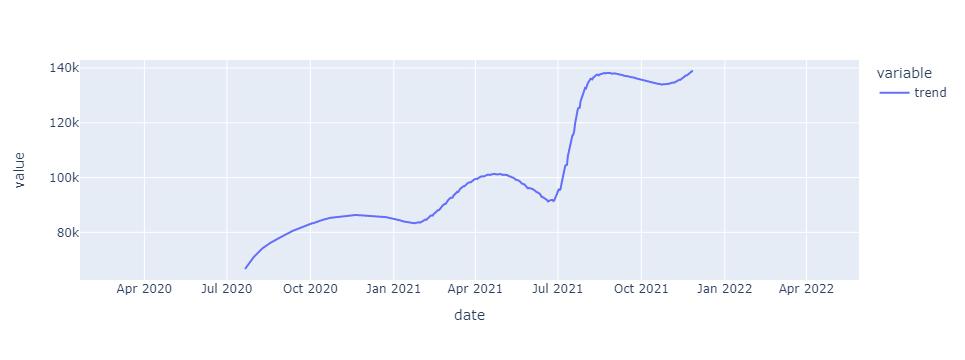

In [15]:
px.line(trend)

# A look into the Case fatality ratio and the Cause-specific mortality ratio

In [16]:
dfpop.rename(columns={"State":"state"},inplace=True)
dfstates = pd.merge(state_timeseries, dfpop[['state','Pop']], how="left", on="state")

In [17]:
dfstates.head()

,date,state,fips,cases,deaths,daily_cases,daily_deaths,Pop
0,2020-03-13,Alabama,1,6,0,0,0,4949697.0
1,2020-03-14,Alabama,1,12,0,6,0,4949697.0
2,2020-03-15,Alabama,1,23,0,11,0,4949697.0
3,2020-03-16,Alabama,1,29,0,6,0,4949697.0
4,2020-03-17,Alabama,1,39,0,10,0,4949697.0


Cause-specific mortality ratio per 1000 people in the US on 2020-12-15: 0.923 Per 1000 people


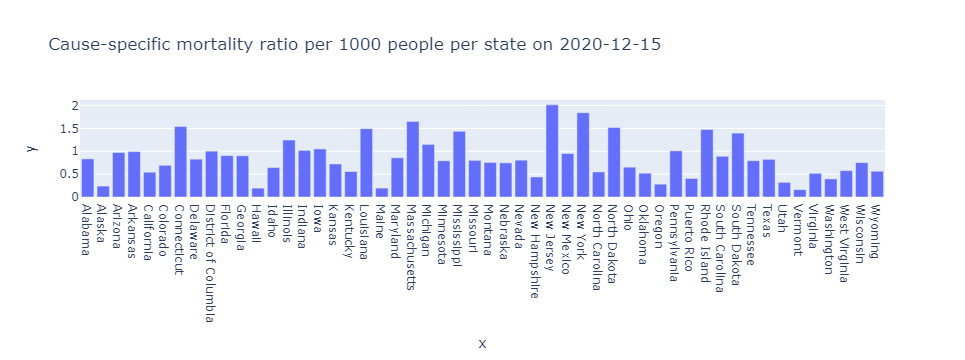

Case to fatality ratio in percent in the US on 2020-12-15: 1.813 %


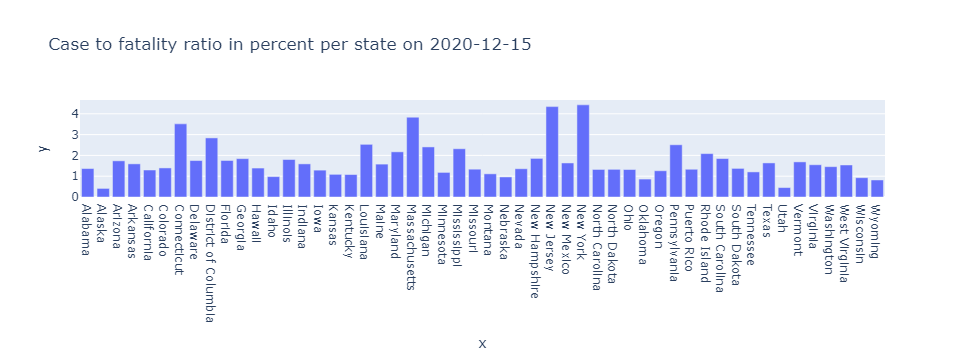

In [18]:
date = '2020-12-15'
print('Cause-specific mortality ratio per 1000 people in the US on {}:'.format(date),
      mda.comp_csr(us_timeseries,date,state=False), 'Per 1000 people')
mda.comp_csr(dfstates,date)


print('Case to fatality ratio in percent in the US on {}:'.format(date),
      mda.comp_cfr(us_timeseries,date,state=False),'%')
mda.comp_cfr(dfstates,date)

In [19]:
date = '2022-05-15'
print('Cause-specific mortality ratio per 1000 people in the US on {}:'.format(date),
      mda.comp_csr(us_timeseries,date,state=False),'per 1000 people')
print('Case to fatality ratio in percent in the US on {}:'.format(date),
      mda.comp_cfr(us_timeseries,date,state=False),'%')

Cause-specific mortality ratio per 1000 people in the US on 2022-05-15: 3.03 per 1000 people
Case to fatality ratio in percent in the US on 2022-05-15: 1.211 %


We can see that even tho the cause-specific mortality ratio increased since the begining of the vaccination campaign, the case to fatality decreased of 0.5%. Thus since people have been getting vaccinated there are less covid related deaths

## Some basic numbers 

In [20]:
#state with the highest total cases, deaths 
h_c_state = dfstates[dfstates['cases']==dfstates['cases'].max()]
date = h_c_state['date'].dt.strftime('%Y-%m-%d').values[0]
state = h_c_state['state'].values[0]
cases = h_c_state['cases'].values[0]
h_d_state = dfstates[dfstates['deaths']==dfstates['deaths'].max()]
date_d = h_d_state['date'].dt.strftime('%Y-%m-%d').values[0]
state_d = h_d_state['state'].values[0]
deaths = h_c_state['deaths'].values[0]
print('The state that has the most cases as of {} is {} with a total of {} cases.'.format(date,state,cases))
print('The state that has the most deaths as of {} is {} with a total of {} deaths.'.format(date_d,state_d,deaths))

The state that has the most cases as of 2022-05-28 is California with a total of 9557347 cases.
The state that has the most deaths as of 2022-05-29 is California with a total of 91463 deaths.


In [21]:
last_upd = us_timeseries.iloc[-1]
tot_cases = last_upd['cases']
tot_deaths = last_upd['deaths']
date = last_upd['date'].strftime('%Y-%m-%d')
print('As of {}, {} people were tested positive and {} people died of COVID-19 in the US.'.format(date,tot_cases,tot_deaths))

As of 2022-05-29, 83931049 people were tested positive and 1003167 people died of COVID-19 in the US.


## Let's have a look at some stocks and the impact of covid 

In [22]:
start_date = us_timeseries['date'].min()
end_date = us_timeseries['date'].max()
stocks = mda.get_stocks('^GSPC','^NDX',start_date,end_date,'sp500','nasdaq')
dfsp500 = stocks[0]
dfndx = stocks[1]
dfstocks = stocks[2]

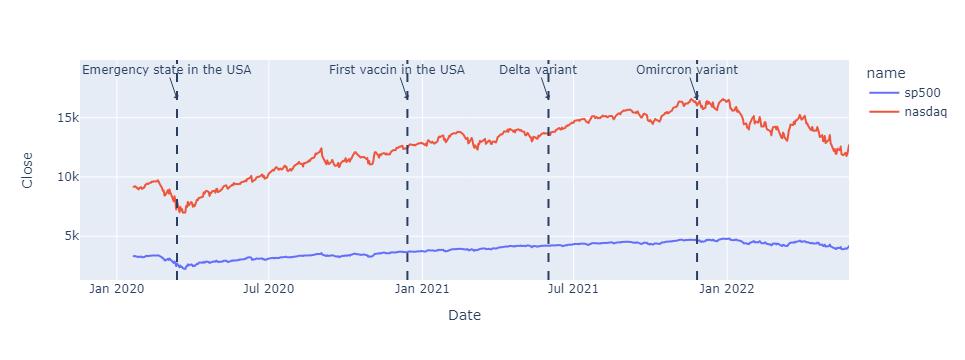

In [23]:
max_y =dfstocks['Close'].max()
fig = px.line(dfstocks,y= 'Close' ,color='name')
fig.add_vline(x='2020-03-13',line_dash="dash") #emergency state in the USA
fig.add_vline(x='2020-12-14',line_dash="dash") #first vaccine in the USA
fig.add_vline(x='2021-06-01',line_dash="dash") #delta variant
fig.add_vline(x='2021-11-26',line_dash="dash") #omicron variant
fig.add_annotation(x='2020-03-13', y=max_y,
            text="Emergency state in the USA",
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x='2020-12-14', y=max_y,
            text="First vaccin in the USA",
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x='2021-06-01', y=max_y,
            text="Delta variant",
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x='2021-11-26', y=max_y,
            text="Omircron variant",
            showarrow=True,
            arrowhead=1)

In [24]:
ndx_changes = mda.changes(dfndx,['2020-03-13','2020-12-14','2021-06-01','2021-11-26'])
sp500_changes = mda.changes(dfsp500,['2020-03-13','2020-12-14','2021-06-01','2021-11-26'])

In [25]:
md("The declaration of the emergency state had a big impact on both s&p500 and nasdaq stock as their values were down by  {}% and {}% respectively. Neither the first vaccin nor the arrival of the delta variant seem to have had an impact   as both stayed on the same trend. The Omicron variant has a small impact on both as their values were down by {}% and {}% after 7 days of the first case."
   .format(round(ndx_changes[0],3),round(sp500_changes[0],3), round(ndx_changes[3],2),round(sp500_changes[3],2)))

The declaration of the emergency state had a big impact on both s&p500 and nasdaq stock as their values were down by  -12.52% and -14.98% respectively. Neither the first vaccin nor the arrival of the delta variant seem to have had an impact   as both stayed on the same trend. The Omicron variant has a small impact on both as their values were down by -1.96% and -1.22% after 7 days of the first case.

### Clustering

In [26]:
df = mapdf.copy(deep=True)

In [27]:
df20_processed, df21_processed, df22_processed = mda.cluster_process(df)

#### 2020

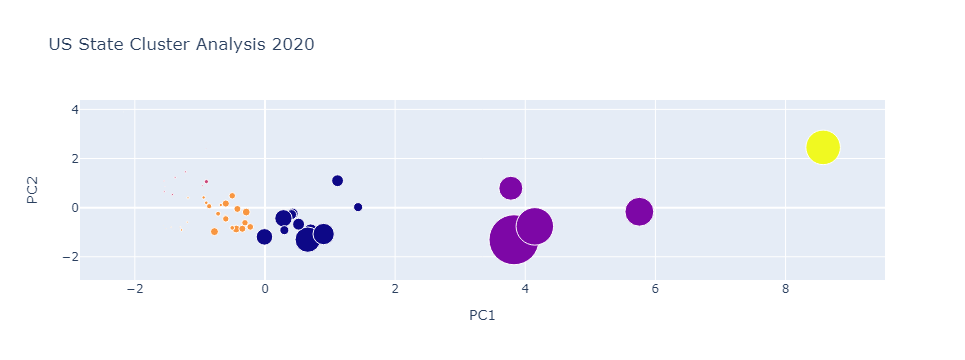

In [28]:
warnings.filterwarnings('ignore')

clusterdf20, Z20, silhoutte20, ari20 = mda.cluster_algorithm(df20_processed, "KMeans")

fig20 = go.Figure(
    data=go.Scatter(
        x=clusterdf20["PC1"].values,
        y=clusterdf20["PC2"].values,
        text=clusterdf20.index,
        mode='markers',
        marker=go.Marker(
            size=df20_processed["deaths"],
            sizemode='diameter',
            sizeref=df20_processed["deaths"].max()/50,
            opacity=1,
            color=Z20
        )
    )
)

fig20.update_layout(
    go.Layout(
        title='US State Cluster Analysis 2020',
        xaxis=go.XAxis(title="PC1", showgrid=True, zeroline=True, showticklabels=True),
        yaxis=go.YAxis(title="PC2", showgrid=True, zeroline=True, showticklabels=True),
        hovermode='closest'
    )
)

fig20.show()

#### 2021

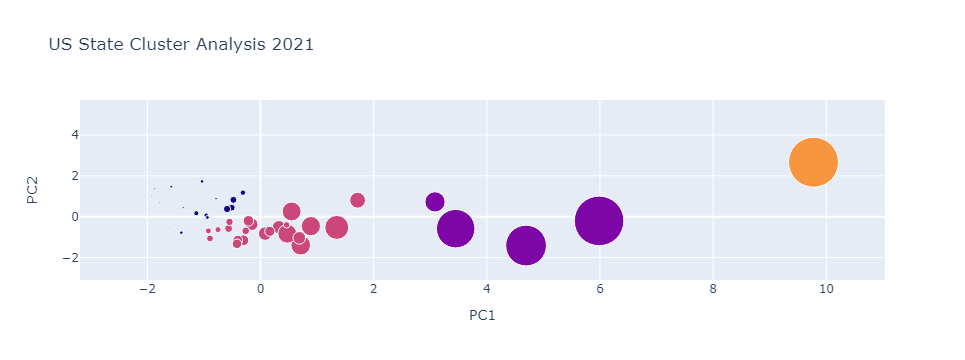

In [29]:
warnings.filterwarnings('ignore')

clusterdf21, Z21, silhoutte21, ari21 = mda.cluster_algorithm(df21_processed, "KMeans")

fig21 = go.Figure(
    data=go.Scatter(
        x=clusterdf21["PC1"].values,
        y=clusterdf21["PC2"].values,
        text=clusterdf21.index,
        mode='markers',
        marker=go.Marker(
            size=df21_processed["deaths"],
            sizemode='diameter',
            sizeref=df21_processed["deaths"].max()/50,
            opacity=1,
            color=Z21
        )
    )
)

fig21.update_layout(
    go.Layout(
        title='US State Cluster Analysis 2021',
        xaxis=go.XAxis(title="PC1", showgrid=True, zeroline=True, showticklabels=True),
        yaxis=go.YAxis(title="PC2", showgrid=True, zeroline=True, showticklabels=True),
        hovermode='closest'
    )
)

fig21.show()

#### 2022

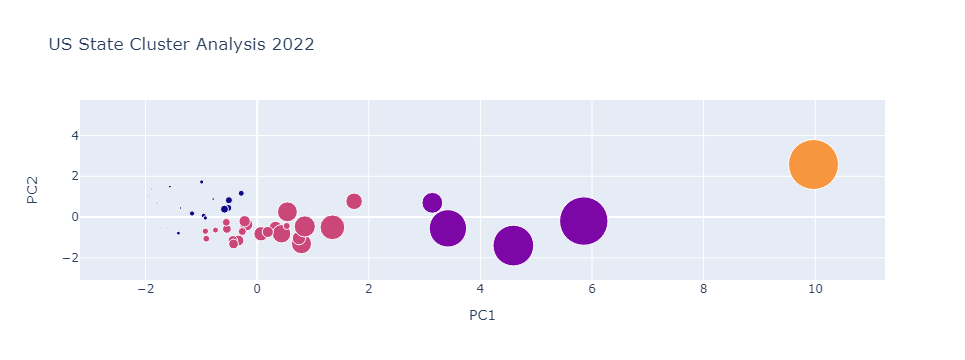

In [30]:
warnings.filterwarnings('ignore')

clusterdf22, Z22, silhoutte22, ari22 = mda.cluster_algorithm(df22_processed, "KMeans")

fig22 = go.Figure(
    data=go.Scatter(
        x=clusterdf22["PC1"].values,
        y=clusterdf22["PC2"].values,
        text=clusterdf22.index,
        mode='markers',
        marker=go.Marker(
            size=df22_processed["deaths"],
            sizemode='diameter',
            sizeref=df22_processed["deaths"].max()/50,
            opacity=1,
            color=Z22
        )
    )
)

fig22.update_layout(
    go.Layout(
        title='US State Cluster Analysis 2022',
        xaxis=go.XAxis(title="PC1", showgrid=True, zeroline=True, showticklabels=True),
        yaxis=go.YAxis(title="PC2", showgrid=True, zeroline=True, showticklabels=True),
        hovermode='closest'
    )
)

fig22.show()

### ANOVA

In [34]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [35]:
anovadf = mda.lmem_process(mapdf)

In [37]:
anova2020 = anovadf[anovadf["year"]==2020]
anova2021 = anovadf[anovadf["year"]==2021]
anova2022 = anovadf[anovadf["year"]==2022]

In [38]:
temp_df = anova2021.copy(deep=True)
temp_df["month"]-=12
month_dict = {1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"August", 9:"September", 10:"October", 11:"November", 12:"December"}
temp_df["month"] = temp_df["month"].map(month_dict)

def fig_creator2(selection):
    import plotly.express as px
    
    title_dict = {"monthly_cases":"Monthly Cases",
                  "monthly_deaths":"Monthly Deaths",
                  "monthly_1dose":"Monthly Vaccination Dose",
                  "monthly_completedose":"Monthly Complete Vaccinations"}
    
    fig = px.strip(temp_df, x='month', y=selection, color="state", title=f"{title_dict[selection]} per month in 2021",
                   hover_data=["monthly_cases", "monthly_deaths", "monthly_1dose", "monthly_completedose"],
                   labels={selection:title_dict[selection]})
    fig.show()

widgets.interact(fig_creator2,
                 selection=widgets.Dropdown(
                     options=[("Monthly Cases", "monthly_cases"),
                              ("Monthly Deaths", "monthly_deaths"),
                              ("Monthly Vaccination Dose", "monthly_1dose"),
                              ("Monthly Complete Vaccinations", "monthly_completedose")],
                     description='Select:'));

interactive(children=(Dropdown(description='Select:', options=(('Monthly Cases', 'monthly_cases'), ('Monthly D…

In [40]:
temp_df = anova2021.copy(deep=True)
temp_df["month"]-=12

def fig_creator3(selection1, selection2):
    import plotly.express as px
    
    title_dict = {"monthly_cases":"Monthly Cases",
                  "monthly_deaths":"Monthly Deaths",
                  "monthly_1dose":"Monthly Vaccination Dose",
                  "monthly_completedose":"Monthly Complete Vaccinations"}
    
    fig = px.scatter(temp_df[temp_df["state"]==selection2], x="month", y=selection1, trendline="ols",
                     title=f"{title_dict[selection1]} in {selection2} 2021",
                    labels={selection1:title_dict[selection1]})
    fig.show()

selection2_options = []
for s in anova2021["state"].unique():
    selection2_options.append((s,s))

widgets.interact(fig_creator3,
                 
                 selection1=widgets.Dropdown(
                     options=[("Monthly Cases", "monthly_cases"),
                              ("Monthly Deaths", "monthly_deaths"),
                              ("Monthly Vaccination Dose", "monthly_1dose"),
                              ("Monthly Complete Vaccinations", "monthly_completedose")],
                     description='Select:'),
                 
                 selection2=widgets.Dropdown(
                     options=selection2_options,
                     description='Select:'));

interactive(children=(Dropdown(description='Select:', options=(('Monthly Cases', 'monthly_cases'), ('Monthly D…

In [26]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [81]:
temp_df = anova2021.copy(deep=True)
temp_df = temp_df[["state", "year", "month", "monthly_cases", "monthly_deaths"]]
temp_df["month"]-=12
month_dict = {1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"August", 9:"September", 10:"October", 11:"November", 12:"December"}
temp_df["month"] = temp_df["month"].map(month_dict)

In [83]:
tempdf_cases = temp_df[["month", "monthly_cases"]]
tempdf_cases["index"] = list(range(49))*12
tempdf_cases = tempdf_cases[["index", "month", "monthly_cases"]]
tempdf_deaths = temp_df[["month", "monthly_deaths"]]
tempdf_deaths["index"] = list(range(49))*12
tempdf_deaths = tempdf_deaths[["index", "month", "monthly_deaths"]]

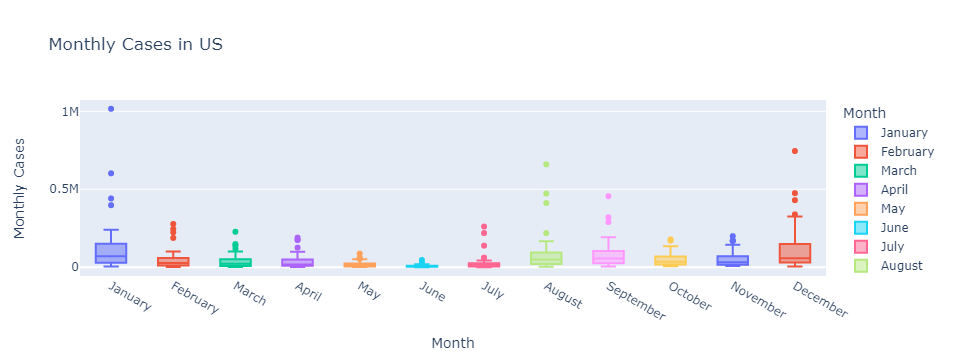

In [89]:
boxplot = px.box(tempdf_cases, x="month", y="monthly_cases",
                 labels={"monthly_cases":"Monthly Cases", "month":"Month"},
                 color="month", title="Monthly Cases in US")
boxplot.show()

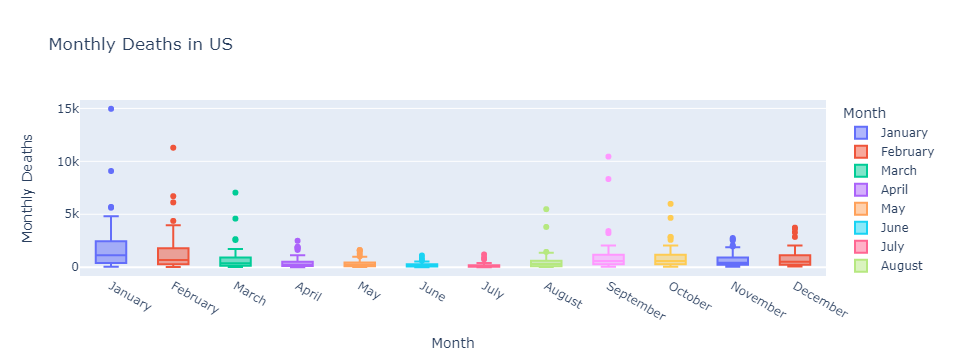

In [90]:
boxplot1 = px.box(tempdf_deaths, x="month", y="monthly_deaths",
                 labels={"monthly_deaths":"Monthly Deaths", "month":"Month"},
                 color="month", title="Monthly Deaths in US")
boxplot1.show()

#### Monthly Cases

In [95]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('monthly_cases ~ month', data=tempdf_cases).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
month,8.011806e+11,11.0,9.658932,3.948505e-16
Residual,4.343413e+12,576.0,NaN,NaN


In [105]:
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=tempdf_cases, res_var='monthly_cases', xfac_var='month', anova_model='monthly_cases ~ month')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,January,February,77065.265306,19492.862790,134637.667822,6.212300,0.001000
1,January,March,88267.061224,30694.658709,145839.463740,7.115286,0.001000
2,January,April,88023.693878,30451.291362,145596.096393,7.095668,0.001000
3,January,May,107404.387755,49831.985239,164976.790271,8.657963,0.001000
4,January,June,118496.857143,60924.454627,176069.259659,9.552137,0.001000
...,...,...,...,...,...,...,...
61,September,November,31190.673469,-26381.729046,88763.075985,2.514308,0.806812
62,September,December,39257.224490,-18315.178026,96829.627006,3.164560,0.519640
63,October,November,2345.877551,-55226.524965,59918.280067,0.189103,0.900000
64,October,December,72793.775510,15221.372994,130366.178026,5.867971,0.002247


#### Monthly Deaths

In [106]:
model = ols('monthly_deaths ~ month', data=tempdf_deaths).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
month,1.458479e+08,11.0,7.843796,9.368774e-13
Residual,9.736517e+08,576.0,NaN,NaN


In [107]:
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=tempdf_deaths, res_var='monthly_deaths', xfac_var='month', anova_model='monthly_deaths ~ month')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,January,February,472.530612,-389.456180,1334.517404,2.544119,0.793646
1,January,March,1149.306122,287.319330,2011.292915,6.187898,0.001000
2,January,April,1444.897959,582.911167,2306.884751,7.779374,0.001000
3,January,May,1557.408163,695.421371,2419.394955,8.385132,0.001000
4,January,June,1726.918367,864.931575,2588.905160,9.297780,0.001000
...,...,...,...,...,...,...,...
61,September,November,445.673469,-416.313323,1307.660262,2.399519,0.857508
62,September,December,286.591837,-575.394955,1148.578629,1.543019,0.900000
63,October,November,248.000000,-613.986792,1109.986792,1.335239,0.900000
64,October,December,88.918367,-773.068425,950.905160,0.478739,0.900000
